In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from IPython.display import clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, InputLayer, Activation, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# adding path so as to import created .py file
import sys
sys.path.append('../') 

# importing a function to visualize live training result 
from plotlearning import PlotLearning       

2025-01-26 20:26:47.087594: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 20:26:47.088185: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 20:26:47.090797: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 20:26:47.098515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737903407.112975   31038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737903407.11

For this notebook we are gonna predict SBIN's stock price 

In [2]:
# data=yf.download("SBIN.NS")
data = pd.read_csv('sbin.csv')

In [3]:
data

,Date,Close,High,Low,Open,Volume
0,1996-01-01,12.205256,12.306202,12.021718,12.119604,43733533
1,1996-01-02,11.816768,12.297023,11.501694,12.251140,56167280
2,1996-01-03,11.501693,12.040069,11.440513,11.884063,68296318
3,1996-01-04,11.461926,11.562871,11.168266,11.348745,86073880
4,1996-01-05,11.397689,11.532282,11.321214,11.501694,76613039
...,...,...,...,...,...,...
7295,2025-01-20,779.250000,785.000000,767.849976,769.000000,9198929
7296,2025-01-21,759.049988,784.900024,756.049988,784.799988,13751780
7297,2025-01-22,753.450012,763.000000,738.000000,762.000000,9908339
7298,2025-01-23,745.900024,755.650024,743.099976,750.000000,10986405


For this notebook we will predict Closing price of 'SBI' stocks 

In [4]:
# data.columns = data.columns.droplevel(1).values

In [5]:
# data.to_csv("sbin.csv",)

In [6]:
df=data[['Date','Close']].copy()

In [7]:
df.head()

,Date,Close
0,1996-01-01,12.205256
1,1996-01-02,11.816768
2,1996-01-03,11.501693
3,1996-01-04,11.461926
4,1996-01-05,11.397689


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7300 non-null   object 
 1   Close   7300 non-null   float64
dtypes: float64(1), object(1)
memory usage: 114.2+ KB


In [9]:
# converting object data type to date time format
df['Date'] = df['Date'].astype('datetime64[ns]',)

Let's see how stock price went over past days

In [10]:
fig=go.Figure()
fig.add_scatter(x=df['Date'],y=df['Close'])
fig.update_layout(template="plotly_dark",
                  hovermode='x unified',
                  xaxis_title="Date",
                  yaxis_title="Close",
                  title="Google's Stock Price")


google's stock price is increasing, how ever a downfall can be seen after the end of year 2021<br>
and its increased after the year 2022 ends  

In [11]:
# Scaling our data as LSTM needs data to be normalizied
le = MinMaxScaler()

scaled_close_price = le.fit_transform(df.iloc[:,1:])

In [12]:
scaled_close_price

array([[0.00315868],
       [0.00272523],
       [0.00237369],
       ...,
       [0.83018619],
       [0.82176246],
       [0.81980993]])

In [13]:
scaled_close_price.shape

(7300, 1)

In [14]:
# defining how many past days model will look and will predict future
backcandles=30      # choosing 30 days 

We need to prepare our data so as <br>
model will train on past 30 days and will predict the future as y 

In [15]:
# reparing the data

X=np.array([scaled_close_price[i:i+backcandles] for i in range(len(scaled_close_price)-backcandles)])

In [16]:
# here is my target column
Y=scaled_close_price[backcandles:,]

In [17]:
X.shape,Y.shape

((7270, 30, 1), (7270, 1))

In [18]:
# we will split 90% of our data as training set, 5% will be validation set and rest will be test set
x_train = X[:int(X.shape[0]*.8)]
y_train = Y[:int(X.shape[0]*.8)]
x_val = X[int(X.shape[0]*.8):int(X.shape[0]*.9)]
y_val = Y[int(X.shape[0]*.8):int(X.shape[0]*.9)]
x_test = X[int(X.shape[0]*.9):]
y_test = Y[int(X.shape[0]*.9):]

In [19]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape,x_val.shape,y_val.shape

((5816, 30, 1), (5816, 1), (727, 30, 1), (727, 1), (727, 30, 1), (727, 1))

In [20]:
# Already saved model for you, so you dont have to
# model = keras.models.load_model("./saved_model")

In [21]:
# defifing LSTM model

model = Sequential()
model.add(LSTM(256,input_shape=(backcandles,x_train.shape[-1]),return_sequences=False))
# model.add(LSTM(32,return_sequences=False))
# model.add(LSTM(16,return_sequences=False))
model.add(Dropout(.1))
model.add(Dense(1,'linear'))

2025-01-26 20:26:49.045548: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/kamal/miniconda3/envs/sbi_sto_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [22]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='mse',metrics=['RootMeanSquaredError'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

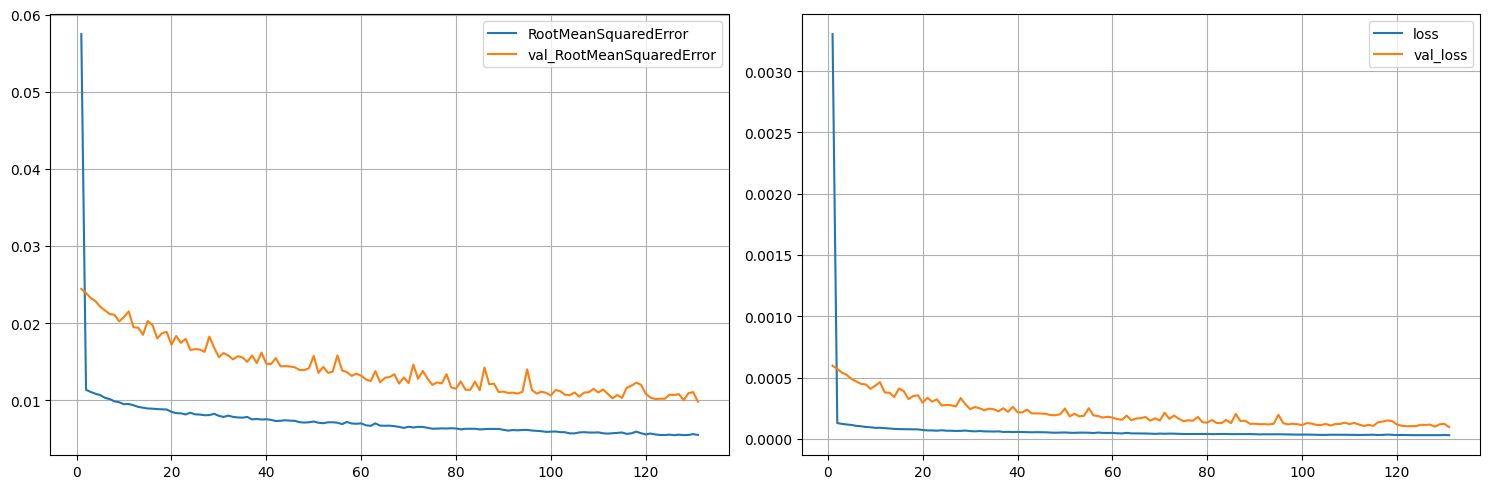

In [ ]:
history = model.fit(x=x_train,y=y_train,
                    validation_data=(x_val,y_val),
                    epochs = 300, batch_size = 64,
                    verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30,verbose=0),PlotLearning()])

In [38]:
# predictions and errors
y_predicted=model.predict(x_test)
print("RMSE : ",np.mean(np.square(y_test-y_predicted)))

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE :  0.00021282630070105474


In [39]:
# the dates availabe in test set
test_dates = df['Date'][-x_test.shape[0]-1:-1]

In [40]:

fig=go.Figure()
fig.add_scatter(x=test_dates,y=le.inverse_transform(y_predicted).ravel(),
                marker=dict(color="#00ffff"),
                name="predictions")
fig.add_scatter(x=test_dates,y=le.inverse_transform(y_test).ravel(),
                marker=dict(color="#ff6200"),
                name="Actual")
fig.update_layout(template="plotly_dark",
                  hovermode='x unified',
                  xaxis_title="Date",
                  yaxis_title="Close",
                  title="A quick comparision")


In [41]:
model.save('model_256.keras')

In [ ]:
# previously we are fedding models actual past value to predict the nextday value
# but what if we give model's predicte value as past value

# Creating a data frame with predited values


updated_x = x_val[-1:]

for i in range(len(x_test)):
    
    updated_x=np.append(updated_x,[model.predict(updated_x[:,-backcandles:],verbose=0)],axis=1)
    


In [ ]:

fig=go.Figure()
fig.add_scatter(x=test_dates,y=le.inverse_transform(updated_x[0][backcandles:]).ravel(),
                marker=dict(color="#00ffff"),
                name="predictions")
fig.add_scatter(x=test_dates,y=le.inverse_transform(y_test).ravel(),
                marker=dict(color="#ff6200"),
                name="Actual")
fig.update_layout(template="plotly_dark",
                  hovermode='x unified',
                  xaxis_title="Date",
                  yaxis_title="Close",
                  title="predictions if past values are unknown")


For a longer run it shows price will decrease but in reaity it should be increasing

So our model perfoms good it we want to predict only tomorrow's Closing price, <br>
But if we want to forcast for a longer peiod of time like in this case we did for 238 days , then its bad <br>
upto 10 days it is giving a suitable result


In [ ]:
# dumping saler

import joblib

joblib.dump(le, "scaler.pkl")


['scaler.pkl']